In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import io
import matplotlib.pyplot as plt
import time
import os
import copy
from glob import glob
from tqdm import tqdm
import warnings
import pandas as pd
from sklearn.metrics import f1_score,accuracy_score,recall_score,roc_auc_score,roc_curve
warnings.simplefilter('ignore')


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
print(torch.cuda.get_device_name())

c:\Users\Zeynep Aygün\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\Zeynep Aygün\AppData\Roaming\Python\Python39\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: [WinError 127] The specified procedure could not be found
  warn(f"Failed to load image Python extension: {e}")


cuda:0
NVIDIA GeForce RTX 3050 Ti Laptop GPU


In [2]:
BATCH_SIZE=2
EPOCH=20
LEARNING_RATE=0.001

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'C:/Users/Zeynep Aygün/Desktop/teknofest_github/Mergen1-Teknofest/zeynep/data/ayrilmis'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                        data_transforms[x])
                    for x in ['train', 'val','test']}
dataloaders = {
    'train': torch.utils.data.DataLoader(image_datasets['train'], batch_size=BATCH_SIZE,
                                            shuffle=True, num_workers=0),
    'val': torch.utils.data.DataLoader(image_datasets['val'], batch_size=BATCH_SIZE,
                                            shuffle=True, num_workers=0),
    'test': torch.utils.data.DataLoader(image_datasets['test'], batch_size=BATCH_SIZE,
                                            shuffle=False, num_workers=0)
                                            }

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val','test']}
class_names = image_datasets['train'].classes
dataset_sizes

{'train': 21596, 'val': 5398, 'test': 4}

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.figure(figsize=(40,40))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [4]:
def train_model(model, criterion, optimizer, scheduler, name, num_epochs=25):

    #Creating a folder to save the model performance.
    try:
        os.mkdir(f'modelPerformance/{name}')
    except:
        print('Dosya var')

    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):

        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            #epochs
            
            epoch=int(len(image_datasets[phase])/BATCH_SIZE)
            
            for _ in tqdm(range(epoch)):
                #Loading Data
                
                inputs, labels = next(iter(dataloaders[phase]))
                
                inputs = inputs.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)

                    labels = labels.to(device)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()
            
            
            #epoch_auc= running_auc/(dataset_sizes[phase]-error)
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            #AUC: {:.4f} , epoch_auc
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(        
                phase, epoch_loss, epoch_acc))
    
            
            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                torch.save(model,'modelPerformance/{}/best_model_{:.4f}acc_{}epochs.h5'.format(name,epoch_acc,num_epochs))

                train_losses = []
                valid_losses = []
            
        print()


    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    
    with open(f'modelPerformance/{name}/'+sorted(os.listdir(f'modelPerformance/{name}/'))[-1], 'rb') as f:
        buffer = io.BytesIO(f.read())
    model=torch.load(buffer)
    # load best model weights
    model.load_state_dict(best_model_wts)

    return model

In [5]:
# A dictionary of models.

modeller={
    'resnet50':models.resnet50(pretrained=True)
}
try:
    os.mkdir('./modelPerformance')
except:
    print('Dosyalar var')

Dosyalar var


In [8]:
models.resnet50(pretrained=True).fc.in_features

2048

In [9]:
for name,model in modeller.items(): 
    model_ft = model
    #model_ft=torch.load('C:/Users/Zeynep Aygün/Desktop/TEKNOFEST/yen/modelPerformance/vit/best_model_0.7244acc_20epochs.h5')
    
    """
    num_ftrs = model_ft.fc.in_features
    model_ft.fc =nn.Sequential(nn.Linear(num_ftrs, len(class_names)), nn.Softmax())"""

    """ num_ftrs=model.heads[-1].in_features
    model_ft.heads[-1]=nn.Sequential(nn.Linear(num_ftrs, len(class_names)), nn.Softmax())"""
    
    num_ftrs=model_ft.fc.in_features
    model_ft.fc =nn.Sequential(nn.Linear(num_ftrs, len(class_names)), nn.Softmax())
    
    model_ft = model_ft.to(device)

    criterion = nn.CrossEntropyLoss()

    # Observe that all parameters are being optimized
    optimizer_ft = optim.SGD(model_ft.parameters(), lr=LEARNING_RATE, momentum=0.9)
    #optimizer_ft = optim.Adam(model_ft.parameters(), lr=LEARNING_RATE)

    # Decay LR by a factor of 0.1 every 7 epochs
    exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=5, gamma=0.0001)

    # TRAINING
    model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, name=name,
                            num_epochs=EPOCH)

Epoch 1/20
----------


100%|██████████| 10798/10798 [22:07<00:00,  8.14it/s]


train Loss: 1.2444 Acc: 0.4882


100%|██████████| 2699/2699 [01:04<00:00, 41.60it/s]


val Loss: 1.1223 Acc: 0.6162

Epoch 2/20
----------


100%|██████████| 10798/10798 [11:03<00:00, 16.27it/s]


train Loss: 1.1309 Acc: 0.6070


100%|██████████| 2699/2699 [01:06<00:00, 40.49it/s]


val Loss: 1.1149 Acc: 0.6215

Epoch 3/20
----------


100%|██████████| 10798/10798 [11:28<00:00, 15.67it/s]


train Loss: 1.0937 Acc: 0.6444


100%|██████████| 2699/2699 [01:11<00:00, 37.81it/s]


val Loss: 1.0778 Acc: 0.6608

Epoch 4/20
----------


100%|██████████| 10798/10798 [10:43<00:00, 16.79it/s]


train Loss: 1.0771 Acc: 0.6627


100%|██████████| 2699/2699 [01:03<00:00, 42.67it/s]


val Loss: 1.0673 Acc: 0.6712

Epoch 5/20
----------


100%|██████████| 10798/10798 [10:55<00:00, 16.47it/s]


train Loss: 1.0765 Acc: 0.6628


100%|██████████| 2699/2699 [01:03<00:00, 42.22it/s]


val Loss: 1.0816 Acc: 0.6541

Epoch 6/20
----------


100%|██████████| 10798/10798 [10:13<00:00, 17.61it/s]


train Loss: 1.0809 Acc: 0.6577


100%|██████████| 2699/2699 [01:03<00:00, 42.74it/s]


val Loss: 1.0905 Acc: 0.6449

Epoch 7/20
----------


100%|██████████| 10798/10798 [10:34<00:00, 17.03it/s]


train Loss: 1.0728 Acc: 0.6674


100%|██████████| 2699/2699 [01:20<00:00, 33.69it/s]


val Loss: 1.0930 Acc: 0.6419

Epoch 8/20
----------


100%|██████████| 10798/10798 [11:07<00:00, 16.18it/s]


train Loss: 1.0830 Acc: 0.6566


100%|██████████| 2699/2699 [01:04<00:00, 41.74it/s]


val Loss: 1.0877 Acc: 0.6484

Epoch 9/20
----------


100%|██████████| 10798/10798 [09:43<00:00, 18.49it/s]


train Loss: 1.0749 Acc: 0.6642


100%|██████████| 2699/2699 [01:03<00:00, 42.48it/s]


val Loss: 1.0865 Acc: 0.6506

Epoch 10/20
----------


100%|██████████| 10798/10798 [10:35<00:00, 16.98it/s]


train Loss: 1.0742 Acc: 0.6650


100%|██████████| 2699/2699 [00:57<00:00, 46.72it/s]


val Loss: 1.0701 Acc: 0.6682

Epoch 11/20
----------


100%|██████████| 10798/10798 [10:03<00:00, 17.90it/s]


train Loss: 1.0771 Acc: 0.6624


100%|██████████| 2699/2699 [01:25<00:00, 31.44it/s]


val Loss: 1.0930 Acc: 0.6451

Epoch 12/20
----------


100%|██████████| 10798/10798 [10:32<00:00, 17.07it/s]


train Loss: 1.0694 Acc: 0.6703


100%|██████████| 2699/2699 [01:02<00:00, 42.86it/s]


val Loss: 1.0836 Acc: 0.6560

Epoch 13/20
----------


100%|██████████| 10798/10798 [10:02<00:00, 17.91it/s]


train Loss: 1.0717 Acc: 0.6670


100%|██████████| 2699/2699 [01:08<00:00, 39.32it/s]


val Loss: 1.0960 Acc: 0.6408

Epoch 14/20
----------


100%|██████████| 10798/10798 [10:17<00:00, 17.50it/s]


train Loss: 1.0696 Acc: 0.6699


100%|██████████| 2699/2699 [01:05<00:00, 41.41it/s]


val Loss: 1.0828 Acc: 0.6523

Epoch 15/20
----------


100%|██████████| 10798/10798 [09:22<00:00, 19.20it/s]


train Loss: 1.0768 Acc: 0.6624


100%|██████████| 2699/2699 [01:06<00:00, 40.84it/s]


val Loss: 1.0877 Acc: 0.6514

Epoch 16/20
----------


100%|██████████| 10798/10798 [09:18<00:00, 19.33it/s]


train Loss: 1.0715 Acc: 0.6685


100%|██████████| 2699/2699 [00:57<00:00, 46.56it/s]


val Loss: 1.0795 Acc: 0.6577

Epoch 17/20
----------


100%|██████████| 10798/10798 [09:39<00:00, 18.62it/s]


train Loss: 1.0700 Acc: 0.6692


100%|██████████| 2699/2699 [00:57<00:00, 46.95it/s]


val Loss: 1.0776 Acc: 0.6601

Epoch 18/20
----------


100%|██████████| 10798/10798 [09:10<00:00, 19.60it/s]


train Loss: 1.0687 Acc: 0.6723


100%|██████████| 2699/2699 [00:57<00:00, 47.26it/s]


val Loss: 1.0889 Acc: 0.6476

Epoch 19/20
----------


100%|██████████| 10798/10798 [09:18<00:00, 19.34it/s]


train Loss: 1.0742 Acc: 0.6658


100%|██████████| 2699/2699 [01:02<00:00, 43.39it/s]


val Loss: 1.0904 Acc: 0.6436

Epoch 20/20
----------


100%|██████████| 10798/10798 [09:24<00:00, 19.14it/s]


train Loss: 1.0692 Acc: 0.6690


100%|██████████| 2699/2699 [00:56<00:00, 47.67it/s]


val Loss: 1.0768 Acc: 0.6595

Training complete in 237m 25s
Best val Acc: 0.671175


In [11]:
import torch
import matplotlib
import numpy as np
import seaborn as sns
from itertools import cycle
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import classification_report

class get_metric():

    def get_accuracy_graph(epochs, train_acc, val_acc):  # draw validation and train accuracy graphs
        plt.plot(epochs, train_acc, color='#006BA4')
        plt.plot(epochs, val_acc, color='#FF800E')
        plt.grid(b=True, which='major', color='lightgray')
        plt.grid(b=True, which='minor', color='lightgray')
        plt.xticks(np.arange(0, 45, 5))
        plt.yticks(np.arange(0.5, 1, 0.05))
        plt.rcParams['figure.figsize'] = (8, 6)
        plt.rcParams['figure.dpi'] = 600
        plt.xlabel("Number of Epochs")
        plt.ylabel("Accuracy")
        plt.title("Training Accuracy vs Validation Accuracy")
        plt.legend(['Training Acc.', 'Validation Acc.'], loc='lower right')
        plt.show()

    def get_loss_graph(epochs, train_losses, val_losses):  # draw validation and train loss graphs
        matplotlib.rcdefaults()
        plt.plot(epochs, train_losses, color='#006BA4')
        plt.plot(epochs, val_losses, color='#FF800E')
        plt.grid(b=True, which='major', color='lightgray')
        plt.grid(b=True, which='minor', color='lightgray')
        plt.xticks(np.arange(0, 45, 5))
        plt.yticks(np.arange(0, 1.2, 0.2))
        plt.rcParams['figure.dpi'] = 600
        plt.xlabel("Number of Epochs")
        plt.ylabel("Loss")
        plt.title("Training Loss vs Validation Loss")
        plt.legend(['Training Loss', 'Validation Loss'], loc='lower right')
        plt.show()

    def test_label_predictions(model, device, test_loader):  # calculate outputs on test dataset for get metrics
        model.eval()
        actuals = []
        predictions = []
        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.to(device), target.to(device)
                model.to(device)
                output = model(data)
                prediction = output.argmax(dim=1, keepdim=True)
                actuals.extend(target.view_as(prediction))
                predictions.extend(prediction)
        return [i.item() for i in actuals], [i.item() for i in predictions]
    
    def test_label_predictions_el2(model_0,model_1,model_2,model_3, device, test_loader):
    
        actuals = []
        predictions = []

        with torch.no_grad():

            for data, target in test_loader:
                data, target = data.to(device), target.to(device)

                outputs_0 = model_0(data).cuda().cpu()
                _, predicted_0 =torch.max(outputs_0.data, 1) 

                outputs_1 = model_1(data)
                _, predicted_1 =torch.max(outputs_1.data, 1) 

                outputs_2 = model_2(data)
                _, predicted_2 =torch.max(outputs_2.data, 1)

                outputs_3 = model_3(data)
                _, predicted_3 =torch.max(outputs_3.data, 1)

                final_pred=predicted_1
                size=final_pred.size()

                for i in range(0,(size[0])):   
                    a=0              
                    if predicted_2[i].item()==0 and predicted_3[i].item()==0:

                        if predicted_1[i].item()==1:
                            final_pred[i]=1

                        if predicted_1[i].item()==0:
                            final_pred[i]=0
                        a+=1

                    if (predicted_0[i].item()==1 and predicted_1[i].item()==1) :

                        a+=1   
                        if predicted_3[i].item()==0:
                            final_pred[i]=0 

                        if predicted_3[i].item()!=0:
                            final_pred[i]=1                    
                    if a==0:                   
                        final_pred[i]=predicted_2[i] 
                actuals.extend(target.view_as(final_pred))
                predictions.extend(final_pred)
        return [i.item() for i in actuals], [i.item() for i in predictions]

    def test_model(model ,device, test_loader):
        correct = 0
        total = 0
        with torch.no_grad():
            for data in test_loader:
                images, labels = data[0].to(device), data[1].to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        print('Correct Prediction: {:d}  Total Images: {:d}'.format(correct, total))
        print('Test Accuracy = {:f}'.format(correct / total))
    
    def test_model_el2(model_0,model_1,model_2,model_3,device, test_loader):
        
        correct = 0
        total = 0

        with torch.no_grad():
            for data in test_loader:

                images, labels = data[0].to(device), data[1].to(device)

                outputs_0 = model_0(images)
                _, predicted_0 =torch.max(outputs_0.data, 1) 

                outputs_1 = model_1(images)
                _, predicted_1 =torch.max(outputs_1.data, 1) 

                outputs_2 = model_2(images)
                _, predicted_2 =torch.max(outputs_2.data, 1)

                outputs_3 = model_3(images)
                _, predicted_3 =torch.max(outputs_3.data, 1)

                final_pred=predicted_1
                size=final_pred.size()

                for i in range(0,(size[0])):   
                    a=0              
                    if predicted_2[i].item()==0 and predicted_3[i].item()==0:

                        if predicted_1[i].item()==1:
                            final_pred[i]=1

                        if predicted_1[i].item()==0:
                            final_pred[i]=0
                        a+=1

                    if (predicted_0[i].item()==1 and predicted_1[i].item()==1):

                        a+=1

                        if predicted_3[i].item()==0:
                            final_pred[i]=0                        
                        if predicted_3[i].item()!=0:
                            final_pred[i]=1
                    if a==0:                   
                        final_pred[i]=predicted_2[i]

                total += labels.size(0)
                correct += (final_pred == labels).sum().item()
        print('Correct Prediction: {:d}  Total Images: {:d}'.format(correct, total))
        print('Test Accuracy = {:f}'.format(correct / total))

    def get_classification_report(truth, predict):  # create classification report for each class with scikit-learn library
        print('Classification Report :\n', classification_report(truth, predict))

    def get_confusion_matrix(actuals, predictions):  # create confusion matrix for each class with scikit-learn library
        matplotlib.rcdefaults()
        print('Confusion matrix:\n',confusion_matrix(actuals, predictions))
        cf_matrix=confusion_matrix(actuals, predictions)
        sns.heatmap(cf_matrix, annot=True,fmt='g', cmap='Blues')

    def get_cohen_kappa(actuals, predictions):  # get cohen kapa score for   determine model performance
        cps = cohen_kappa_score(actuals, predictions)
        print('Kappa Score of this model:\n', cps)

    def test_class_probabilities(model, device, test_loader, which_class):
        
        truths = []
        probabilities = []
        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.to(device), target.to(device)
                output = model(data).cuda().cpu()
                prediction = output.argmax(dim=1, keepdim=True)
                truths.extend(target.view_as(prediction) == which_class)
                probabilities.extend(np.exp(output[:, which_class]))
        return [i.item() for i in truths], [i.item() for i in probabilities]
    def test_class_probabilities_el2(model_0,model_1,model_2,model_3, device, test_loader, which_class):
    
        truths = []
        probabilities = []

        with torch.no_grad():
            for data, target in test_loader:

                data, target = data.to(device), target.to(device)

                outputs_0 = model_0(data)
                _, predicted_0 =torch.max(outputs_0.data, 1) 

                outputs_1 = model_1(data)
                _, predicted_1 =torch.max(outputs_1.data, 1) 

                outputs_2 = model_2(data)
                _, predicted_2 =torch.max(outputs_2.data, 1)

                outputs_3 = model_3(data)
                _, predicted_3 =torch.max(outputs_3.data, 1)

                final_pred=predicted_1
                out=outputs_1
                size=final_pred.size()

                for i in range(0,(size[0])):   
                    a=0              
                    if predicted_2[i].item()==0 and predicted_3[i].item()==0:

                        if predicted_1[i].item()==1:
                            #final_pred[i]=1
                            out[i]=outputs_1[i]

                        if predicted_1[i].item()==0:
                            final_pred[i]=0
                            out[i]=outputs_1[i]
                        a+=1

                    if (predicted_0[i].item()==1 and predicted_1[i].item()==1):

                        a+=1

                        if predicted_3[i].item()==0:
                            #final_pred[i]=0
                            out[i]=outputs_3[i]

                        if predicted_3[i].item()!=0:
                            #final_pred[i]=1
                            out[i]=outputs_3[i]
                    if a==0:                   
                        #final_pred[i]=predicted_2[i]
                        out[i]=outputs_2[i]
                prediction = out.argmax(dim=1, keepdim=True)
                truths.extend(target.view_as(prediction) == which_class)
                probabilities.extend(np.exp(out.cuda().cpu()[:, which_class]))
        return [i.item() for i in truths], [i.item() for i in probabilities]
    
    def get_roc_curves_el2(model_0,model_1,model_2,model_3, device, data):  # draw Roc curves and calculate auc score for each class
        fpr = dict()
        tpr = dict()
        roc_auc = dict()

        actuals, class_probabilities = get_metric.test_class_probabilities_el2(model_0,model_1,model_2,model_3, device, data, 0)
        fpr[0], tpr[0], _ = roc_curve(actuals, class_probabilities)
        roc_auc[0] = roc_auc_score(actuals, class_probabilities)

        actuals, class_probabilities = get_metric.test_class_probabilities_el2(model_0,model_1,model_2,model_3, device, data, 1)
        fpr[1], tpr[1], _ = roc_curve(actuals, class_probabilities)
        roc_auc[1] = roc_auc_score(actuals, class_probabilities)

        print("Auc Score For Each Class: ", roc_auc)

        matplotlib.rcdefaults()
        plt.figure()
        colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
        for i, color in zip(range(2), colors):
            plt.plot(fpr[i], tpr[i], color=color, lw=1,
            label='ROC curve of class {0} (area = {1:0.4f})'
            ''.format(i, roc_auc[i]))
        plt.plot([0, 1], [0, 1], 'k--', lw=1)
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.legend(loc="lower right")
        plt.show()

    def get_roc_curves(model, device, data):  # draw Roc curves and calculate auc score for each class
        fpr = dict()
        tpr = dict()
        roc_auc = dict()

        actuals, class_probabilities = get_metric.test_class_probabilities(model, device, data, 0)
        fpr[0], tpr[0], _ = roc_curve(actuals, class_probabilities)
        roc_auc[0] = roc_auc_score(actuals, class_probabilities)

        actuals, class_probabilities = get_metric.test_class_probabilities(model, device, data, 1)
        fpr[1], tpr[1], _ = roc_curve(actuals, class_probabilities)
        roc_auc[1] = roc_auc_score(actuals, class_probabilities)

        actuals, class_probabilities = get_metric.test_class_probabilities(model, device, data, 2)
        fpr[2], tpr[2], _ = roc_curve(actuals, class_probabilities)
        roc_auc[2] = roc_auc_score(actuals, class_probabilities)

        actuals, class_probabilities = get_metric.test_class_probabilities(model, device, data, 3)
        fpr[3], tpr[3], _ = roc_curve(actuals, class_probabilities)
        roc_auc[3] = roc_auc_score(actuals, class_probabilities)

        print("Auc Score For Each Class: ", roc_auc)

        matplotlib.rcdefaults()
        plt.figure()
        colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
        for i, color in zip(range(2), colors):
            plt.plot(fpr[i], tpr[i], color=color, lw=1,
                label='ROC curve of class {0} (area = {1:0.4f})'
                    ''.format(i, roc_auc[i]))
        plt.plot([0, 1], [0, 1], 'k--', lw=1)
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.legend(loc="lower right")
        plt.show()



swin_v2_s
-----------------
F1 Score: 0.0 0.7224540901502504 0.6845675522894291
Recall: 0.0 0.9034446764091858 0.6242268041237113 
Precision: 0.0 0.6018776077885952 0.7578222778473092


Classification Report :
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       596
           1       0.60      0.90      0.72      1916
           2       0.76      0.62      0.68      1940
           3       0.72      0.70      0.71       946

    accuracy                           0.67      5398
   macro avg       0.52      0.56      0.53      5398
weighted avg       0.61      0.67      0.63      5398

Correct Prediction: 3605  Total Images: 5398
Test Accuracy = 0.667840
Kappa Score of this model:
 0.5075440002230616


Confusion matrix:
 [[   0  584    1   11]
 [   0 1731  138   47]
 [   0  526 1211  203]
 [   0   35  248  663]]




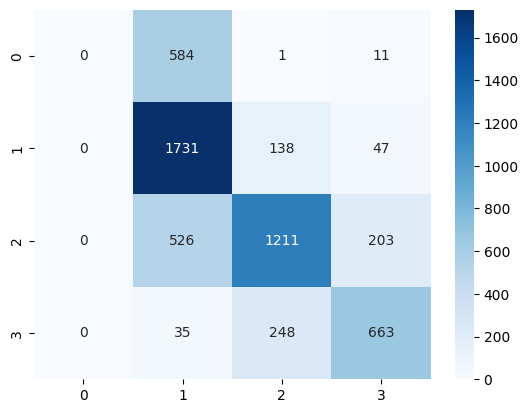

In [12]:
from sklearn.metrics import f1_score,accuracy_score,recall_score,roc_auc_score,roc_curve,confusion_matrix,precision_score,recall_score
print('\n'+'swin_v2_s'+'\n-----------------')  
model_ft=torch.load('C:/Users/Zeynep Aygün/Desktop/teknofest_github/Mergen1-Teknofest/zeynep/modelPerformance/resnet50/best_model_0.6712acc_20epochs.h5')
phase='val'
actuals, predictions = get_metric.test_label_predictions(model_ft, device, dataloaders[phase])
f1=f1_score(predictions,actuals,average=None)
recall=recall_score(actuals,predictions,average=None)
precision=precision_score(actuals,predictions,average=None)
print(f'F1 Score: {f1[0]} {f1[1]} {f1[2]}')
print(f'Recall: {recall[0]} {recall[1]} {recall[2]} ')
print(f'Precision: {precision[0]} {precision[1]} {precision[2]}')
print('\n')
get_metric.get_classification_report(actuals, predictions)
get_metric.test_model(model_ft,device,dataloaders[phase])
get_metric.get_cohen_kappa(actuals, predictions)
print('\n')
get_metric.get_confusion_matrix(actuals, predictions)
print('\n')
#get_metric.get_roc_curves(model_ft, device,  dataloaders[phase])

In [3]:
!pip install openpyxl


     -------------------------------------- 250.0/250.0 kB 1.7 MB/s eta 0:00:00
  Using cached et_xmlfile-1.1.0-py3-none-any.whl (4.7 kB)



[notice] A new release of pip is available: 23.0.1 -> 23.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
import pandas as pd


df1 = pd.read_excel("C:/Users/Zeynep Aygün/Desktop/veribilgisi.xlsx")


df2 = pd.read_excel('C:/Users/Zeynep Aygün/Desktop/veribilgisi_ilk.xlsx')


df = pd.concat([df1, df2])


df.to_excel('birlesik_dosya.xlsx', index=False)


In [6]:
import pandas as pd


df1 = pd.read_excel("C:/Users/Zeynep Aygün/Desktop/veribilgisi.xlsx")
df2 = pd.read_excel("C:/Users/Zeynep Aygün/Desktop/veribilgisi_ilk.xlsx")

merged_df = pd.concat([df1, df2], ignore_index=True)

duplicates = merged_df[merged_df.duplicated()]

print("Tekrar eden öğeler:\n", duplicates)


Tekrar eden öğeler:
 Empty DataFrame
Columns: [HASTANO, BIRADS KATEGORİSİ, MEME KOMPOZİSYONU, KADRAN BİLGİSİ (SAĞ), KADRAN BİLGİSİ (SOL), Birads Skoru (EK BİLGİ OLARAK VERİLMİŞTİR, YARIŞMADA İSTENMEYECEKTİR)]
Index: []


In [1]:
import pandas as pd


df1 = pd.read_excel("C:/Users/Zeynep Aygün/Desktop/okul/deneme.xlsx")
df2 = pd.read_excel("C:/Users/Zeynep Aygün/Desktop/okul/veribilgisi_31_01_23.xlsx")

merged_df = pd.concat([df1, df2], ignore_index=True)

duplicates = merged_df[merged_df.duplicated()]

print("Tekrar eden öğeler:\n", duplicates)


Tekrar eden öğeler:
 Empty DataFrame
Columns: [HASTANO, BIRADS KATEGORİSİ, MEME KOMPOZİSYONU, KADRAN BİLGİSİ (SAĞ), KADRAN BİLGİSİ (SOL), Birads Skoru (EK BİLGİ OLARAK VERİLMİŞTİR, YARIŞMADA İSTENMEYECEKTİR)]
Index: []


In [ ]:
import pandas as pd

df1 = pd.read_excel("C:/Users/Zeynep Aygün/Desktop/okul/deneme.xlsx")
df2 = pd.read_excel("C:/Users/Zeynep Aygün/Desktop/okul/veribilgisi_31_01_23.xlsx")

merged_df = pd.concat([df1, df2], ignore_index=True)

duplicates = merged_df[merged_df.duplicated(subset=['HASTANO'])]

print("Tekrar eden öğeler:\n", duplicates)


In [13]:
import pandas as pd

df1 = pd.read_excel("C:/Users/Zeynep Aygün/Desktop/okul/deneme.xlsx")
df2 = pd.read_excel("C:/Users/Zeynep Aygün/Desktop/okul/veribilgisi_31_01_23.xlsx")

merged_df = pd.concat([df1, df2], ignore_index=True)

duplicates = merged_df[merged_df.duplicated(subset=['BIRADS KATEGORİSİ'])]['BIRADS KATEGORİSİ']
duplicates2 = merged_df[merged_df.duplicated(subset=['MEME KOMPOZİSYONU'])]['MEME KOMPOZİSYONU']



print("BIRADS",len(duplicates))
print("KOMPOZİSYON",len(duplicates2))


BIRADS 7954
KOMPOZİSYON 7953


In [17]:
import pandas as pd

df1 = pd.read_excel("C:/Users/Zeynep Aygün/Desktop/okul/deneme.xlsx")
df2 = pd.read_excel("C:/Users/Zeynep Aygün/Desktop/okul/veribilgisi_31_01_23.xlsx")

merged_df = pd.merge(df1, df2, on=["BIRADS KATEGORİSİ", "MEME KOMPOZİSYONU"], how="inner")

print("Ortak değer sayısı:", merged_df.shape[0])


Ortak değer sayısı: 243488
